# 八. 卷积神经网络(`convolutional network`)

卷积网络(Lecun, 1989)，也叫作卷积神经网络，是一种专门用来处理具有类似网格结构的数据的神经网络。例如时间序列数据（可以认为是在时间轴上有规律地采样行程的一维网格）和图像数据（可以看作是二维的像素网格）。卷积网络在诸多应用领域都表现优异。“卷积神经网络”一词表明该网络使用了卷积（convolutional）这种数学运算。卷积是一种特殊的线性运算。卷积网络是指那些至少在网络的一层中使用卷积运算来替代一般的矩阵乘法运算的神经网络。

## 1. 二维互相关

虽然卷积层得名于卷积（convolution）运算，但我们通常在卷积层中使用更加直观的互相关（cross-correlation）运算。在二维卷积层中，一个二维输入数组和一个二维核（kernel）数组通过互相关运算输出一个二维数组。

我们用一个具体例子来解释二维互相关运算的含义。如图9.1所示，输入是一个高和宽均为3的二维数组。我们将该数组的形状记为$3 \times 3$或（3，3）。核数组的高和宽分别为2。该数组在卷积计算中又称卷积核或过滤器（filter）。卷积核窗口（又称卷积窗口）的形状取决于卷积核的高和宽，即$2 \times 2$。图9.1中的阴影部分为第一个输出元素及其计算所使用的输入和核数组元素：$0\times0+1\times1+3\times2+4\times3=19$。

<div align=center>
<img width="250" src="../pictures/9.1-correlation.svg"/>
</div>
<div align=center>图9.1 二维互相关运算</div>


在二维互相关运算中，卷积窗口从输入数组的最左上方开始，按从左往右、从上往下的顺序，依次在输入数组上滑动。当卷积窗口滑动到某一位置时，窗口中的输入子数组与核数组按元素相乘并求和，得到输出数组中相应位置的元素。图5.1中的输出数组高和宽分别为2，其中的4个元素由二维互相关运算得出：

$$
0\times0+1\times1+3\times2+4\times3=19,\\
1\times0+2\times1+4\times2+5\times3=25,\\
3\times0+4\times1+6\times2+7\times3=37,\\
4\times0+5\times1+7\times2+8\times3=43.\\
$$

下面我们将上述过程实现在`corr2d`函数里。它接受输入数组`X`与核数组`K`，并输出数组`Y`。

In [1]:
%matplotlib inline
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torch
import torchvision.transforms as transforms
import numpy as np
import gzip
import os
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats("svg")

In [166]:
def corr2d(X, K):
    '''
    X: 输入
    K: 核
    '''
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = torch.sum(X[i: i + h, j: j + w] * K)
    return Y

In [157]:
X = torch.tensor([[0, 1, 2], 
                  [3, 4, 5], 
                  [6, 7, 8]])
K = torch.tensor([[0, 1], 
                  [2, 3]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

## 2. 二维卷积

二维卷积层将输入和卷积核做互相关运算，并加上一个标量偏差来得到输出。卷积层的模型参数包括了卷积核和标量偏差。在训练模型的时候，通常我们先对卷积核随机初始化，然后不断迭代卷积核和偏差。

下面基于`corr2d`函数来实现一个自定义的二维卷积层。在构造函数`__init__`里我们声明`weight`和`bias`这两个模型参数。前向计算函数`forward`则是直接调用`corr2d`函数再加上偏差。

In [154]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super(Conv2D, self).__init__()
        self.weight = nn.Parameter(torch.randn(kernel_size))
        self.bias = nn.Parameter(torch.randn(1))
    
    def corr2d(self, X):
        h, w = self.weight.shape
        Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
        for i in range(Y.shape[0]):
            for j in range(Y.shape[1]):
                Y[i, j] = torch.sum(X[i: i + h, j: j + w] * self.weight)
        return Y

    def forward(self, X):
        return self.corr2d(X) + self.bias

卷积窗口形状为$p \times q$的卷积层称为$p \times q$卷积层。同样，$p \times q$卷积或$p \times q$卷积核说明卷积核的高和宽分别为$p$和$q$。

### 物体边缘检测
下面我们来看一个卷积层的简单应用：检测图像中物体的边缘，即找到像素变化的位置。首先我们构造一张$6\times 8$的图像（即高和宽分别为6像素和8像素的图像）。它中间4列为黑（0），其余为白（1）。

In [167]:
X = torch.ones(6, 8)
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

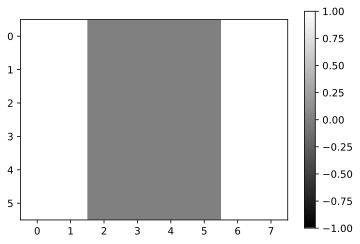

In [182]:
plt.figure()
plt.imshow(X.numpy(), cmap='gray', vmin=-1, vmax=1)
plt.colorbar()
# plt.axis(False)
plt.grid(False)

然后我们构造一个高和宽分别为1和2的卷积核`K`。当它与输入做互相关运算时，如果横向相邻元素相同，输出为0；否则输出为非0。

In [169]:
K = torch.tensor([[1, -1]])
h, w = K.shape
Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
        Y[i, j] = torch.sum(X[i: i + h, j: j + w] * K)

Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

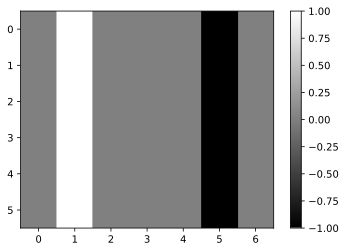

In [183]:
plt.figure()
plt.imshow(Y.numpy(), cmap='gray', vmin=-1, vmax=1)
plt.colorbar()
# plt.axis(False)
plt.grid(False)

由此，我们可以看出，卷积层可通过重复使用卷积核有效地表征局部空间。

- 通过数据学习核数组

最后我们来看一个例子，它使用物体边缘检测中的输入数据`X`和输出数据`Y`来学习我们构造的核数组`K`。我们首先构造一个卷积层，其卷积核将被初始化成随机数组。接下来在每一次迭代中，我们使用平方误差来比较`Y`和卷积层的输出，然后计算梯度来更新权重。


In [155]:
conv2d = Conv2D(kernel_size=(1, 2))  # 构建卷积类，其中核为1*2

step = 40
lr = 0.5
for i in range(step):
    Y_hat = conv2d(X)
    l = torch.mean((Y_hat - Y) ** 2)
    l.backward()
    
    # 梯度下降
    conv2d.weight.data -= lr * conv2d.weight.grad
    conv2d.bias.data -= lr * conv2d.bias.grad
    
    # 梯度清0
    conv2d.weight.grad.data.zero_()
    conv2d.bias.grad.data.zero_()
    if (i + 1) % 5 == 0:
        print('Step %d, loss %.3f' % (i + 1, l.item()))

Step 5, loss 0.023
Step 10, loss 0.002
Step 15, loss 0.000
Step 20, loss 0.000
Step 25, loss 0.000
Step 30, loss 0.000
Step 35, loss 0.000
Step 40, loss 0.000


In [153]:
print("weight: ", conv2d.weight.data)
print("bias: ", conv2d.bias.data)

weight:  tensor([[ 0.9979, -0.9979]])
bias:  tensor([-6.3908e-06])


- 互相关运算和卷积运算

实际上，卷积运算与互相关运算类似。**为了得到卷积运算的输出，我们只需将核数组左右翻转并上下翻转，再与输入数组做互相关运算**。可见，卷积运算和互相关运算虽然类似，但如果它们使用相同的核数组，对于同一个输入，输出往往并不相同。

那么，你也许会好奇卷积层为何能使用互相关运算替代卷积运算。**其实，在深度学习中核数组都是学出来的：卷积层无论使用互相关运算或卷积运算都不影响模型预测时的输出**。为了解释这一点，假设卷积层使用互相关运算学出图9.1中的核数组。设其他条件不变，使用卷积运算学出的核数组即图5.1中的核数组按上下、左右翻转。也就是说，图9.1中的输入与学出的已翻转的核数组再做卷积运算时，依然得到图5.1中的输出。为了与大多数深度学习文献一致，如无特别说明，本书中提到的卷积运算均指互相关运算。

- 特征图和感受野

二维卷积层输出的二维数组可以看作是输入在空间维度（宽和高）上某一级的表征，也叫**特征图（feature map）**。影响元素$x$的前向计算的所有可能输入区域（可能大于输入的实际尺寸）叫做$x$的**感受野（receptive field）**。以图9.1为例，输入中阴影部分的四个元素是输出中阴影部分元素的感受野。我们将图中形状为$2 \times 2$的输出记为$Y$，并考虑一个更深的卷积神经网络：将$Y$与另一个形状为$2 \times 2$的核数组做互相关运算，输出单个元素$z$。那么，$z$在$Y$上的感受野包括$Y$的全部四个元素，在输入上的感受野包括其中全部9个元素。可见，我们可以通过更深的卷积神经网络使特征图中单个元素的感受野变得更加广阔，从而捕捉输入上更大尺寸的特征。

>我们常使用“元素”一词来描述数组或矩阵中的成员。在神经网络的术语中，这些元素也可称为“单元”。当含义明确时，不对这两个术语做严格区分。

## 3. 填充和步幅

在上一节的例子里，我们使用高和宽为3的输入与高和宽为2的卷积核得到高和宽为2的输出。一般来说，假设输入形状是$n_h\times n_w$，卷积核窗口形状是$k_h\times k_w$，那么输出形状将会是

$$(n_h-k_h+1) \times (n_w-k_w+1).$$

所以卷积层的输出形状由输入形状和卷积核窗口形状决定。本节我们将介绍卷积层的两个超参数，即**填充和步幅**。它们可以对给定形状的输入和卷积核改变输出形状。

### 3.1 填充

**填充（padding）**是指在输入高和宽的两侧填充元素（通常是0元素）。图9.2里我们在原输入高和宽的两侧分别添加了值为0的元素，使得输入高和宽从3变成了5，并导致输出高和宽由2增加到4。图9.2中的阴影部分为第一个输出元素及其计算所使用的输入和核数组元素：$0\times0+0\times1+0\times2+0\times3=0$。

<div align=center>
<img width="400" src="../pictures/9.2-conv_pad.svg"/>
</div>
<div align=center>图9.2 在输入的高和宽两侧分别填充了0元素的二维互相关计算</div>

一般来说，如果在高的两侧一共填充$p_h$行，在宽的两侧一共填充$p_w$列，那么输出形状将会是

$$(n_h-k_h+p_h+1)\times(n_w-k_w+p_w+1),$$

也就是说，输出的高和宽会分别增加$p_h$和$p_w$。

在很多情况下，我们会设置$p_h=k_h-1$和$p_w=k_w-1$来使输入和输出具有相同的高和宽。这样会方便在构造网络时推测每个层的输出形状。假设这里$k_h$是奇数，我们会在高的两侧分别填充$p_h/2$行。如果$k_h$是偶数，一种可能是在输入的顶端一侧填充$\lceil p_h/2\rceil$行，而在底端一侧填充$\lfloor p_h/2\rfloor$行。在宽的两侧填充同理。

**卷积神经网络经常使用奇数高宽的卷积核，如1、3、5和7，所以两端上的填充个数相等**。对任意的二维数组`X`，设它的第`i`行第`j`列的元素为`X[i,j]`。当两端上的填充个数相等，并使输入和输出具有相同的高和宽时，我们就知道输出`Y[i,j]`是由输入以`X[i,j]`为中心的窗口同卷积核进行互相关计算得到的。

下面的例子里我们创建一个高和宽为3的二维卷积层，然后设输入高和宽两侧的填充数分别为1。给定一个高和宽为8的输入，我们发现输出的高和宽也是8。

In [51]:
_input = torch.rand(2, 3, 5, 5)
conv2d = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=4, padding=1)  # 注意：padding为左右，上下各加上padding行或列的元素
_output = conv2d(_input)
_output.shape  # 2, 3, (5 - 4 + 1 + 2), (5 - 4 + 1 + 2)

torch.Size([2, 3, 4, 4])

In [52]:
# 定义一个函数来计算卷积层。它对输入和输出做相应的升维和降维
def comp_conv2d(conv2d, X):
    X = X.view((1, 1) + X.shape)  # (N, C, H, W)
    Y = conv2d(X)
    return Y.view(Y.shape[2:])  # 排除不关心的前两维：批量和通道

# 注意这里是两侧分别填充1行或列，所以在两侧一共填充2行或列
conv2d = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1)  # 3 - 2

X = torch.rand(8, 8)
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

当卷积核的高和宽不同时，我们也可以通过设置高和宽上不同的填充数使输出和输入具有相同的高和宽。

In [53]:
# 使用高为5、宽为3的卷积核。在高和宽两侧的填充数分别为2和1
conv2d = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(5, 3), padding=(2, 1))  # 5 - 4， 3 - 2
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

### 3.2 步幅

在上一节里我们介绍了二维互相关运算。卷积窗口从输入数组的最左上方开始，按从左往右、从上往下的顺序，依次在输入数组上滑动。**我们将每次滑动的行数和列数称为步幅（stride）**。

目前我们看到的例子里，在高和宽两个方向上步幅均为1。我们也可以使用更大步幅。图9.3展示了在高上步幅为3、在宽上步幅为2的二维互相关运算。可以看到，输出第一列第二个元素时，卷积窗口向下滑动了3行，而在输出第一行第二个元素时卷积窗口向右滑动了2列。当卷积窗口在输入上再向右滑动2列时，由于输入元素无法填满窗口，无结果输出。图9.3中的阴影部分为输出元素及其计算所使用的输入和核数组元素：$0\times0+0\times1+1\times2+2\times3=8$、$0\times0+6\times1+0\times2+0\times3=6$。

<div align=center>
<img width="400" src="../pictures/9.3-conv_stride.svg"/>
</div>
<div align=center>图9.3 高和宽上步幅分别为3和2的二维互相关运算</div>

一般来说，当高上步幅为$s_h$，宽上步幅为$s_w$时，输出形状为

$$\lfloor(n_h-k_h+p_h+s_h)/s_h\rfloor \times \lfloor(n_w-k_w+p_w+s_w)/s_w\rfloor.$$

如果设置$p_h=k_h-1$和$p_w=k_w-1$，那么输出形状将简化为$\lfloor(n_h+s_h-1)/s_h\rfloor \times \lfloor(n_w+s_w-1)/s_w\rfloor$。更进一步，如果输入的高和宽能分别被高和宽上的步幅整除，那么输出形状将是$(n_h/s_h) \times (n_w/s_w)$。

下面我们令高和宽上的步幅均为2，从而使输入的高和宽减半。

In [54]:
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

接下来是一个稍微复杂点儿的例子。

In [56]:
X.shape

torch.Size([8, 8])

In [55]:
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape  # (8 - 3 + 3) / 3, (8 - 5 + 2 + 4) / 4

torch.Size([2, 2])

为了表述简洁，当输入的高和宽两侧的填充数分别为$p_h$和$p_w$时，我们称填充为$(p_h, p_w)$。特别地，当$p_h = p_w = p$时，填充为$p$。当在高和宽上的步幅分别为$s_h$和$s_w$时，我们称步幅为$(s_h, s_w)$。特别地，当$s_h = s_w = s$时，步幅为$s$。在默认情况下，填充为0，步幅为1。

## 4. 多输入通道和多输出通道

前面两节里我们用到的输入和输出都是二维数组，但真实数据的维度经常更高。例如，彩色图像在高和宽2个维度外还有RGB（红、绿、蓝）3个颜色通道。假设彩色图像的高和宽分别是$h$和$w$（像素），那么它可以表示为一个$3\times h\times w$的多维数组。我们将大小为3的这一维称为通道（channel）维。本节我们将介绍含多个输入通道或多个输出通道的卷积核。

### 4.1 多输入通道

当输入数据含多个通道时，我们需要构造一个输入通道数与输入数据的通道数相同的卷积核，从而能够与含多通道的输入数据做互相关运算。假设输入数据的通道数为$c_i$，那么卷积核的输入通道数同样为$c_i$。设卷积核窗口形状为$k_h\times k_w$。当$c_i=1$时，我们知道卷积核只包含一个形状为$k_h\times k_w$的二维数组。当$c_i > 1$时，我们将会为每个输入通道各分配一个形状为$k_h\times k_w$的核数组。把这$c_i$个数组在输入通道维上连结，即得到一个形状为$c_i\times k_h\times k_w$的卷积核。由于输入和卷积核各有$c_i$个通道，我们可以在各个通道上对输入的二维数组和卷积核的二维核数组做互相关运算，再将这$c_i$个互相关运算的二维输出按通道相加，得到一个二维数组。这就是含多个通道的输入数据与多输入通道的卷积核做二维互相关运算的输出。

图9.4展示了含2个输入通道的二维互相关计算的例子。在每个通道上，二维输入数组与二维核数组做互相关运算，再按通道相加即得到输出。图9.4中阴影部分为第一个输出元素及其计算所使用的输入和核数组元素：$(1\times1+2\times2+4\times3+5\times4)+(0\times0+1\times1+3\times2+4\times3)=56$。

<div align=center>
<img width="400" src="../pictures/9.4-conv_multi_in.svg"/>
</div>
<div align=center>图9.4 含2个输入通道的互相关计算</div>


接下来我们实现含多个输入通道的互相关运算。我们只需要对每个通道做互相关运算，然后通过`add_n`函数来进行累加。

In [159]:
def corr2d_multi_in(X, K):
    # 沿着X和K的第0维（通道维）分别计算再相加
    res = 0
    for i in range(X.shape[0]):
        res += corr2d(X[i, :, :], K[i, :, :])
    return res

我们可以构造图9.4中的输入数组`X`、核数组`K`来验证互相关运算的输出。

In [160]:
X = torch.tensor([[[0, 1, 2], [3, 4, 5], [6, 7, 8]],
              [[1, 2, 3], [4, 5, 6], [7, 8, 9]]])
K = torch.tensor([[[0, 1], [2, 3]], [[1, 2], [3, 4]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

### 4.2 多输出通道

**当输入通道有多个时，因为我们对各个通道的结果做了累加，所以不论输入通道数是多少，输出通道数总是为1**。设卷积核输入通道数和输出通道数分别为$c_i$和$c_o$，高和宽分别为$k_h$和$k_w$。如果希望得到含多个通道的输出，我们可以为每个输出通道分别创建**形状为$c_i\times k_h\times k_w$的核数组**。将它们在输出通道维上连结，卷积核的形状即$c_o\times c_i\times k_h\times k_w$。在做互相关运算时，每个输出通道上的结果由卷积核在该输出通道上的核数组与整个输入数组计算而来。

下面我们实现一个互相关运算函数来计算多个通道的输出。

In [161]:
def corr2d_multi_in_out(X, K):
    # 对K的第0维遍历，每次同输入X做互相关计算。所有结果使用stack函数合并在一起
    return torch.stack([corr2d_multi_in(X, k) for k in K])

In [164]:
a = torch.tensor([1, 2, 3])
b = torch.tensor([4, 5, 6])
c = torch.tensor([7, 8, 9])
torch.stack([a, b, c])

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

我们将核数组`K`同`K+1`（`K`中每个元素加一）和`K+2`连结在一起来构造一个输出通道数为3的卷积核。

In [162]:
K = torch.stack([K, K + 1, K + 2])  # 卷积核组
K.shape  # torch.Size([3, 2, 2, 2])

torch.Size([3, 2, 2, 2])

下面我们对输入数组`X`与核数组`K`做互相关运算。此时的输出含有3个通道。其中第一个通道的结果与之前输入数组`X`与多输入通道、单输出通道核的计算结果一致。

In [163]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

### 4.3 $1\times 1$卷积层

最后我们讨论卷积窗口形状为$1\times 1$（$k_h=k_w=1$）的多通道卷积层。我们通常称之为$1\times 1$卷积层，并将其中的卷积运算称为$1\times 1$卷积。因为使用了最小窗口，$1\times 1$卷积失去了卷积层可以识别高和宽维度上相邻元素构成的模式的功能。实际上，$1\times 1$卷积的主要计算发生在通道维上。图9.5展示了使用输入通道数为3、输出通道数为2的$1\times 1$卷积核的互相关计算。值得注意的是，输入和输出具有相同的高和宽。输出中的每个元素来自输入中在高和宽上相同位置的元素在不同通道之间的按权重累加。假设我们将通道维当作特征维，将高和宽维度上的元素当成数据样本，**那么$1\times 1$卷积层的作用与全连接层等价**。

> `1*1`卷积核对应权重矩阵

<div align=center>
<img width="400" src="../pictures/9.5-conv_1x1.svg"/>
</div>
<div align=center>图9.5 1x1卷积核的互相关计算。输入和输出具有相同的高和宽</div>


下面我们使用全连接层中的矩阵乘法来实现$1\times 1$卷积。这里需要在矩阵乘法运算前后对数据形状做一些调整。

In [77]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.view(c_i, h * w)
    K = K.view(c_o, c_i)
    Y = torch.mm(K, X)  # 全连接层的矩阵乘法
    return Y.view(c_o, h, w)

经验证，做$1\times 1$卷积时，以上函数与之前实现的互相关运算函数`corr2d_multi_in_out`等价。

In [78]:
X = torch.rand(3, 3, 3)
K = torch.rand(2, 3, 1, 1)

Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)

(Y1 - Y2).norm().item() < 1e-6

True

在之后的模型里我们将会看到$1\times 1$卷积层被当作保持高和宽维度形状不变的全连接层使用。于是，我们可以通过调整网络层之间的通道数来控制模型复杂度。

## 5. 池化层

回忆一下，在图像物体边缘检测应用中，我们构造卷积核从而精确地找到了像素变化的位置。设任意二维数组`X`的`i`行`j`列的元素为`X[i, j]`。如果我们构造的卷积核输出`Y[i, j]=1`，那么说明输入中`X[i, j]`和`X[i, j+1]`数值不一样。这可能意味着物体边缘通过这两个元素之间。但实际图像里，我们感兴趣的物体不会总出现在固定位置：即使我们连续拍摄同一个物体也极有可能出现像素位置上的偏移。这会导致同一个边缘对应的输出可能出现在卷积输出`Y`中的不同位置，进而对后面的模式识别造成不便。

在本节中我们介绍池化（pooling）层，它的提出是**为了缓解卷积层对位置的过度敏感性**。

### 5.1 二维最大池化层和平均池化层

同卷积层一样，池化层每次对输入数据的一个固定形状窗口（又称池化窗口）中的元素计算输出。不同于卷积层里计算输入和核的互相关性，池化层直接计算池化窗口内元素的最大值或者平均值。该运算也分别叫做最大池化或平均池化。在二维最大池化中，池化窗口从输入数组的最左上方开始，按从左往右、从上往下的顺序，依次在输入数组上滑动。当池化窗口滑动到某一位置时，窗口中的输入子数组的最大值即输出数组中相应位置的元素。

<div align=center>
<img width="300" src="../pictures/9.6-pooling.svg"/>
</div>
<div align=center>图9.6 池化窗口形状为 2 x 2 的最大池化</div>

图9.6展示了池化窗口形状为$2\times 2$的最大池化，阴影部分为第一个输出元素及其计算所使用的输入元素。输出数组的高和宽分别为2，其中的4个元素由取最大值运算$\text{max}$得出：

$$
\max(0,1,3,4)=4,\\
\max(1,2,4,5)=5,\\
\max(3,4,6,7)=7,\\
\max(4,5,7,8)=8.\\
$$


二维平均池化的工作原理与二维最大池化类似，但将最大运算符替换成平均运算符。池化窗口形状为$p \times q$的池化层称为$p \times q$池化层，其中的池化运算叫作$p \times q$池化。

让我们再次回到本节开始提到的物体边缘检测的例子。现在我们将卷积层的输出作为$2\times 2$最大池化的输入。设该卷积层输入是`X`、池化层输出为`Y`。无论是`X[i, j]`和`X[i, j+1]`值不同，还是`X[i, j+1]`和`X[i, j+2]`不同，池化层输出均有`Y[i, j]=1`。也就是说，使用$2\times 2$最大池化层时，只要卷积层识别的模式在高和宽上移动不超过一个元素，我们依然可以将它检测出来。

下面把池化层的前向计算实现在`pool2d`函数里。它跟二维卷积层里`corr2d`函数非常类似，唯一的区别在计算输出`Y`上。

In [79]:
def pool2d(X, pool_size, mode='max'):
    X = X.float()
    p_h, p_w = pool_size
    Y = torch.zeros(X.shape[0] - p_h + 1, X.shape[1] - p_w + 1)
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()       
    return Y

我们可以构造图9.6中的输入数组`X`来验证二维最大池化层的输出。

In [80]:
X = torch.tensor([[0, 1, 2], [3, 4, 5], [6, 7, 8]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

同时我们实验一下平均池化层。

In [81]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

### 5.2 填充和步幅

同卷积层一样，池化层也可以在输入的高和宽两侧的填充并调整窗口的移动步幅来改变输出形状。池化层填充和步幅与卷积层填充和步幅的工作机制一样。我们将通过`nn`模块里的二维最大池化层`MaxPool2d`来演示池化层填充和步幅的工作机制。我们先构造一个形状为(1, 1, 4, 4)的输入数据，前两个维度分别是批量和通道。

In [82]:
X = torch.arange(16, dtype=torch.float).view((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

默认情况下，`MaxPool2d`实例里步幅和池化窗口形状相同。下面使用形状为(3, 3)的池化窗口，默认获得形状为(3, 3)的步幅。

In [83]:
pool2d = nn.MaxPool2d(3)
pool2d(X) 

tensor([[[[10.]]]])

我们可以手动指定步幅和填充。

In [84]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

当然，我们也可以指定非正方形的池化窗口，并分别指定高和宽上的填充和步幅。

In [85]:
pool2d = nn.MaxPool2d((2, 4), padding=(1, 2), stride=(2, 3))
pool2d(X)

tensor([[[[ 1.,  3.],
          [ 9., 11.],
          [13., 15.]]]])

### 5.3 多通道

在处理多通道输入数据时，**池化层对每个输入通道分别池化，而不是像卷积层那样将各通道的输入按通道相加**。这意味着池化层的输出通道数与输入通道数相等。下面将数组`X`和`X+1`在通道维上连结来构造通道数为2的输入。

In [86]:
X = torch.cat((X, X + 1), dim=1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

池化后，我们发现输出通道数仍然是2。

In [87]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

# 6. LeNet

我们之前对`Fashion-MNIST`数据集中的图像进行分类。每张图像高和宽均是28像素。我们将图像中的像素逐行展开，得到长度为784的向量，并输入进全连接层中。然而，这种分类方法有一定的局限性。

1. 图像在同一列邻近的像素在这个向量中可能相距较远。它们构成的模式可能难以被模型识别。
2. 对于大尺寸的输入图像，使用全连接层容易造成模型过大。假设输入是高和宽均为1000像素的彩色照片（含3个通道）。即使全连接层输出个数仍是256，该层权重参数的形状是$3,000,000\times 256$：它占用了大约3 GB的内存或显存。这带来过复杂的模型和过高的存储开销。

卷积层尝试解决这两个问题：

- 一方面，卷积层保留输入形状，使图像的像素在高和宽两个方向上的相关性均可能被有效识别；
- 另一方面，卷积层通过滑动窗口将同一卷积核与不同位置的输入重复计算，从而避免参数尺寸过大。

**卷积神经网络就是含卷积层的网络**。本节里我们将介绍一个早期用来识别手写数字图像的卷积神经网络：`LeNet`。这个名字来源于`LeNet`论文的第一作者`Yann LeCun`。`LeNet`展示了通过梯度下降训练卷积神经网络可以达到手写数字识别在当时最先进的结果。这个奠基性的工作第一次将卷积神经网络推上舞台，为世人所知。LeNet的网络结构如下图所示。

<div align=center>
<img width="600" src="../pictures/9.7-lenet.png"/>
</div>
<div align=center>LeNet网络结构</div>

### 6.1 LeNet模型

`LeNet`分为卷积层块和全连接层块两个部分。下面我们分别介绍这两个模块。

卷积层块里的基本单位是卷积层后接最大池化层：卷积层用来识别图像里的空间模式，如线条和物体局部，之后的最大池化层则用来降低卷积层对位置的敏感性。卷积层块由两个这样的基本单位重复堆叠构成。在卷积层块中，每个卷积层都使用$5\times 5$的窗口，并在输出上使用`sigmoid`激活函数。第一个卷积层输出通道数为6，第二个卷积层输出通道数则增加到16。这是因为第二个卷积层比第一个卷积层的输入的高和宽要小，所以增加输出通道使两个卷积层的参数尺寸类似。卷积层块的两个最大池化层的窗口形状均为$2\times 2$，且步幅为2。由于池化窗口与步幅形状相同，池化窗口在输入上每次滑动所覆盖的区域互不重叠。

卷积层块的输出形状为(批量大小, 通道, 高, 宽)。当卷积层块的输出传入全连接层块时，全连接层块会将小批量中每个样本变平（flatten）。也就是说，全连接层的输入形状将变成二维，其中第一维是小批量中的样本，第二维是每个样本变平后的向量表示，且向量长度为通道、高和宽的乘积。全连接层块含3个全连接层。它们的输出个数分别是120、84和10，其中10为输出的类别个数。

下面我们通过`Sequential`类来实现LeNet模型。

In [88]:
import time
from torch import nn, optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [88]:
class LeNet(nn.Module):
    '''
    输入数据X的格式为: (N, C, H, W), N表示样本量, C为通道量, H为高, W为宽
    '''
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, 5), # in_channels, out_channels, kernel_size 6*(28-5+1)*(28-5+1)
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2), # kernel_size, stride 6*(24/2)*(24/2)
            nn.Conv2d(6, 16, 5),  # 16*(12-5+1)*(12-5+1)
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2)  # 16*(8/2)*(8/2)
        )
        self.fc = nn.Sequential(
            nn.Linear(16*4*4, 120),
            nn.Sigmoid(),
            nn.Linear(120, 84),
            nn.Sigmoid(),
            nn.Linear(84, 10)
        )

    def forward(self, img):
        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0], -1))
        return output

In [89]:
device

device(type='cpu')

接下来查看每个层的形状。

In [90]:
net = LeNet()
print(net)

LeNet(
  (conv): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Sigmoid()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Sigmoid()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


可以看到，在卷积层块中输入的高和宽在逐层减小。卷积层由于使用高和宽均为5的卷积核，从而将高和宽分别减小4，而池化层则将高和宽减半，但通道数则从1增加到16。全连接层则逐层减少输出个数，直到变成图像的类别数10。

### 6.2 获取数据和训练模型

下面我们来实验LeNet模型。实验中，我们仍然使用Fashion-MNIST作为训练数据集。

In [110]:
def load_mnist(path, kind='train'):
    """
    Load MNIST data from `path`
    """
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte.gz'% kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte.gz'% kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 784)
    
    features = transforms.ToTensor()(images)  # (h, w, c) -> (c, h, w)
    labels = torch.LongTensor(labels)

    return features[0], labels

In [115]:
def data_loader(features, labels, batch_size, is_one_hot=True):
    '''
    构建小批量数据集
    '''
    features = features.view(features.shape[0], 1, 28, 28)  # 设置为 N*C*H*W
    if is_one_hot:
        hot_labels = torch.zeros(features.shape[0], 10)
        x_indices = np.arange(features.shape[0]).tolist()
        y_indices = labels.byte().tolist()
        hot_labels[x_indices, y_indices] = 1
        dataset = TensorDataset(features, hot_labels)
    else:
        dataset = TensorDataset(features, labels)

    return DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

In [93]:
label_names = ['短袖圆领T恤', '裤子', '套衫', '连衣裙', '外套', '凉鞋', '衬衫', '运动鞋','包', '短靴']
text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

In [111]:
features, labels = load_mnist(path="../dataset/fashion_mnist")
test_features, test_labels = load_mnist(path="../dataset/fashion_mnist", kind="t10k")

In [119]:
batch_size = 256
train_iter = data_loader(features, labels, batch_size, is_one_hot=False)
test_iter = data_loader(test_features, test_labels, batch_size, is_one_hot=False)

In [120]:
for X, y in train_iter:
    print(X.shape)
    break

torch.Size([256, 1, 28, 28])


因为卷积神经网络计算比多层感知机要复杂，建议使用GPU来加速计算。因此，我们对3.6节（softmax回归的从零开始实现）中描述的`evaluate_accuracy`函数略作修改，使其支持GPU计算。

In [96]:
def evaluate_accuracy(data_iter, net, device=None):
    if device is None and isinstance(net, torch.nn.Module):
        # 如果没指定device就使用net的device
        device = list(net.parameters())[0].device
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(net, torch.nn.Module):
                net.eval() # 评估模式, 这会关闭dropout
                acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
                net.train() # 改回训练模式
            else: # 自定义的模型, 不考虑GPU
                if('is_training' in net.__code__.co_varnames): # 如果有is_training这个参数
                    # 将is_training设置成False
                    acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item() 
                else:
                    acc_sum += (net(X).argmax(dim=1) == y).float().sum().item() 
            n += y.shape[0]
    return acc_sum / n

学习率采用0.001，训练算法使用Adam算法，损失函数使用交叉熵损失函数。

In [140]:
num_epochs = 10
net = net.to(device)
print("training on ", device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

training on  cpu


In [145]:
for epoch in range(num_epochs):
    train_l_sum, train_acc_sum, n, batch_count, start = 0.0, 0.0, 0, 0, time.perf_counter()
    for X, y in train_iter:
        X = X.to(device)  # 将张量复制到设备device
        y = y.to(device)  # 将张量复制到设备device
        y_hat = net(X)
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        train_l_sum += l.cpu().item()
        train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
        n += y.shape[0]
        batch_count += 1
    test_acc = evaluate_accuracy(test_iter, net)
    print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
          % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.perf_counter() - start))

epoch 1, loss 0.3167, train acc 0.881, test acc 0.861, time 8.4 sec
epoch 2, loss 0.3156, train acc 0.881, test acc 0.862, time 8.4 sec
epoch 3, loss 0.3127, train acc 0.882, test acc 0.861, time 8.4 sec
epoch 4, loss 0.3087, train acc 0.883, test acc 0.864, time 8.4 sec
epoch 5, loss 0.3092, train acc 0.884, test acc 0.865, time 8.5 sec
epoch 6, loss 0.3083, train acc 0.883, test acc 0.863, time 8.4 sec
epoch 7, loss 0.3051, train acc 0.885, test acc 0.860, time 8.4 sec
epoch 8, loss 0.3046, train acc 0.885, test acc 0.860, time 8.4 sec
epoch 9, loss 0.3020, train acc 0.887, test acc 0.864, time 8.5 sec
epoch 10, loss 0.3017, train acc 0.887, test acc 0.863, time 8.4 sec


## 参考资料

1. [邱锡鹏. 神经网络与机器学习. 2020.](https://nndl.github.io/)
2. [阿斯顿·张、李沐、扎卡里 C. 立顿、亚历山大 J. 斯莫拉等. 动手学深度学习. 2020.](https://github.com/d2l-ai/d2l-zh)
3. [动手学深度学习(Pytoch实现)](https://github.com/ShusenTang/Dive-into-DL-PyTorch)
4. [Michael Nielsen. Neural network and deep learning. 2016. MIT press](http://neuralnetworksanddeeplearning.com/)
5. [Ian Goodfellow, Yoshua Bengio, Aaron Courville. Deep learning. 2016.](https://www.deeplearningbook.org/)
6. LeCun, Y., Bottou, L., Bengio, Y., & Haffner, P. (1998). Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11), 2278-2324.